In [ ]:
!pip install yfinance fredapi pandas_datareader --quiet
!pip install arch --quiet
!pip install wbdata --quiet
!pip install --upgrade wbdata --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.9/982.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 7.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
bigframes 1.18.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.
moviepy 1.0.3 requires decorator<5.0,>=4.0.2, but you have decorator 5.1.1 which is incompatible.


In [ ]:
import yfinance as yf
import pandas_datareader.data as web
import wbdata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from arch import arch_model
from tqdm import tqdm
import datetime

usd_try = yf.download('TRY=X', start='2015-01-01', end='2024-09-25')

turkey_interest = web.DataReader('IR3TIB01TRM156N', 'fred', start='2015-01-01')
us_interest = web.DataReader('DFF', 'fred', start='2015-01-01')
turkey_cpi = web.DataReader('TURCPIALLMINMEI', 'fred', start='2015-01-01')
us_cpi = web.DataReader('CPIAUCSL', 'fred', start='2015-01-01')
oil_prices = web.DataReader('DCOILBRENTEU', 'fred', start='2015-01-01')

indicators = {'SL.UEM.TOTL.ZS': 'Turkey_Unemployment_Rate'}

data_dates = (datetime.datetime(2015, 1, 1), datetime.datetime(2024, 9, 25))

us_unemployment = web.DataReader('UNRATE', 'fred', start='2015-01-01')

us_unemployment.rename(columns={'UNRATE': 'US_Unemployment_Rate'}, inplace=True)

us_unemployment = preprocess_data(us_unemployment)

us_gdp = web.DataReader('GDP', 'fred', start='2015-01-01')

# Forward-fill and backward-fill missing values to handle gaps
def preprocess_data(df):
    return df.ffill().bfill()

# Apply preprocessing
turkey_interest = preprocess_data(turkey_interest)
us_interest = preprocess_data(us_interest)
turkey_cpi = preprocess_data(turkey_cpi)
us_cpi = preprocess_data(us_cpi)
oil_prices = preprocess_data(oil_prices)
us_gdp = preprocess_data(us_gdp)

# Rename columns
us_interest.rename(columns={'DFF': 'US_Interest_Rate'}, inplace=True)
turkey_cpi.rename(columns={'TURCPIALLMINMEI': 'Turkey_CPI'}, inplace=True)
us_cpi.rename(columns={'CPIAUCSL': 'US_CPI'}, inplace=True)
oil_prices.rename(columns={'DCOILBRENTEU': 'Oil_Price'}, inplace=True)
us_gdp.rename(columns={'GDP': 'US_GDP'}, inplace=True)

usd_try['Log_Returns'] = np.log(usd_try['Close'] / usd_try['Close'].shift(1))
log_returns = usd_try['Log_Returns'].dropna()

plt.figure(figsize=(12, 6))
plt.plot(usd_try.index, usd_try['Close'], label='USD/TRY')
plt.title('Historical USD/TRY Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(usd_try.index, usd_try['Log_Returns'], label='Daily Log Returns')
plt.axhline(0, color='black', linestyle='--')
plt.title('USD/TRY Daily Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.grid(True)
plt.show()

forecast_horizons = [30, 60, 90]

for h in forecast_horizons:
    usd_try[f'Realized_Vol_{h}d'] = usd_try['Log_Returns'].rolling(window=h).std() * np.sqrt(252)

print("\nRealized Volatility:")
print(usd_try[[f'Realized_Vol_{h}d' for h in forecast_horizons]].head())

data = pd.concat([
    usd_try['Log_Returns'],
    us_interest,
    turkey_cpi,
    us_cpi,
    oil_prices,
    us_gdp,
    us_unemployment
], axis=1)

corr_columns = [
    'Log_Returns',
    'US_Interest_Rate',
    'Turkey_CPI',
    'US_CPI',
    'Oil_Price',
    'US_GDP',
    'US_Unemployment_Rate'
]
corr_data = data[corr_columns]

corr_matrix = corr_data.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of USD/TRY and Selected Macroeconomic Indicators')
plt.show()


[*********************100%***********************]  1 of 1 completed


NameError: name 'preprocess_data' is not defined

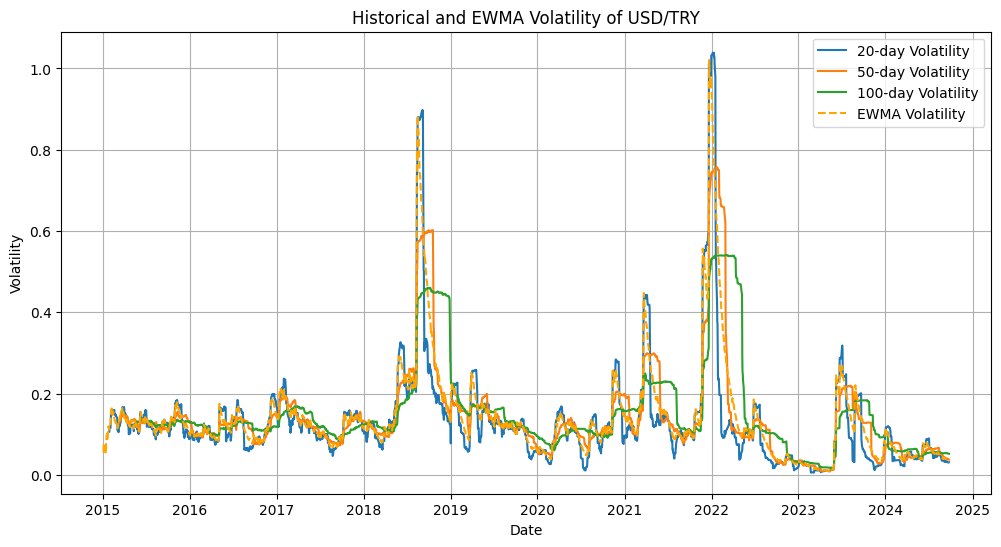

In [ ]:
# Rolling historical volatility for 20, 50, and 100 days
for window in [20, 50, 100]: # loops over window sizes
    # Calculates rolling standard deviation which is measure of how much returns vary
    # Annualized by multiplying it by square root of 252(number of trading days in year)
    # New columns are added to usd_try data frame for each window size ex:'Hist_Vol_100d'
    usd_try[f'Hist_Vol_{window}d'] = usd_try['Log_Returns'].rolling(window).std() * np.sqrt(252)


# EWMA volatility
lambda_ = 0.94 # Smoothing factor controls how quickly past observation weights decay
usd_try['EWMA_Volatility'] = usd_try['Log_Returns'].ewm(alpha=1 - lambda_).std() * np.sqrt(252)

# Plot historical and EWMA volatility
plt.figure(figsize=(12, 6))
plt.plot(usd_try.index, usd_try['Hist_Vol_20d'], label='20-day Volatility')
plt.plot(usd_try.index, usd_try['Hist_Vol_50d'], label='50-day Volatility')
plt.plot(usd_try.index, usd_try['Hist_Vol_100d'], label='100-day Volatility')
plt.plot(usd_try.index, usd_try['EWMA_Volatility'], label='EWMA Volatility', linestyle='--', color='orange')
plt.title('Historical and EWMA Volatility of USD/TRY')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Install necessary packages
!pip install arch --quiet

import arch

# Drop NaN values
log_returns = usd_try['Log_Returns'].dropna()*10  # Scaling for better numerical stability

# Fit GARCH(1,1) model
from arch import arch_model

model = arch_model(log_returns, vol='Garch', p=1, q=1, dist='normal')
garch_result = model.fit(disp='off')

print(garch_result.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2903.74
Distribution:                  Normal   AIC:                          -5799.48
Method:            Maximum Likelihood   BIC:                          -5776.13
                                        No. Observations:                 2535
Date:                Thu, Sep 26 2024   Df Residuals:                     2534
Time:                        02:46:18   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         5.6785e-03  1.253e-03      4.532  5.830e-06 [3.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0136. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Streaming output truncated to the last 5000 lines.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01869. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01869. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by eith

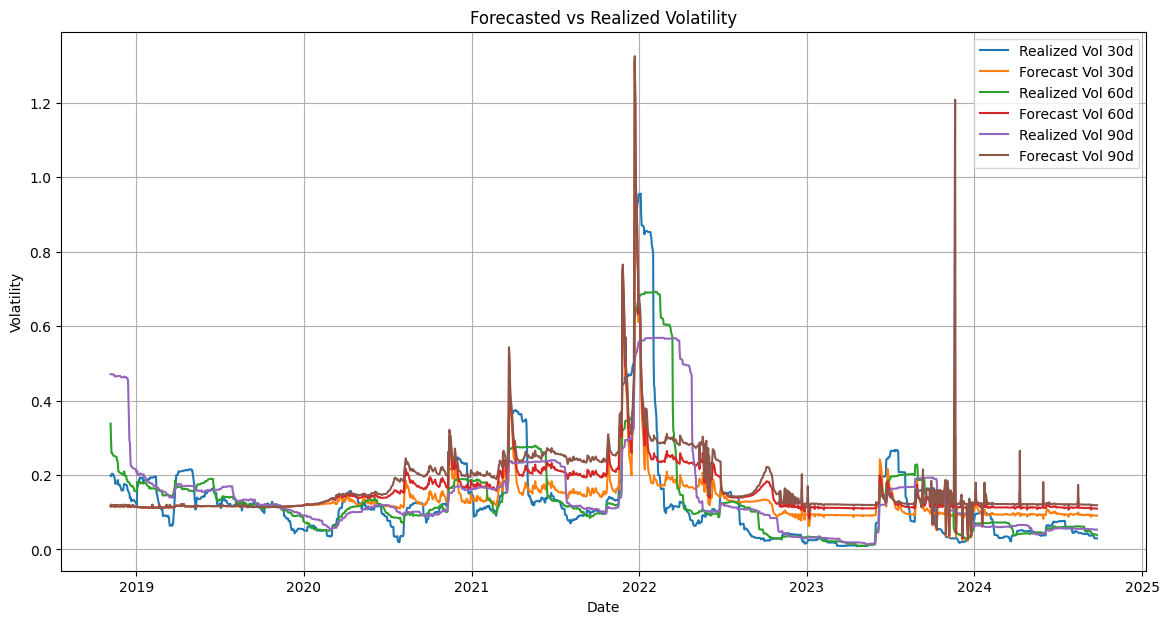

In [ ]:
from tqdm import tqdm

# function with data df, rolling window size, and forecast horizons in days
#  (future time steps for vol forcast to be made)
def rolling_garch_forecast(data, window, horizons):
    """
    Perform rolling GARCH forecasts.

    Parameters:
    - data: Pandas Series of log returns.
    - window: Number of observations in the rolling window.
    - horizons: List of forecast horizons (in days).

    Returns:
    - forecasts_df: DataFrame containing forecasted volatilities for each horizon.
    """

    #
    forecasts = {h: [] for h in horizons}

    # empty list that will store dates for which forcasts are made
    forecast_dates = []

    # traverses over time series data with rolling window
    # runs though last 'window' amount of values
    # at each iteration the window of data wil be used to fit the GARCH model
    for start in tqdm(range(len(data) - window)):
        end = start + window
        # slices data frame from start to end to train GARCH model
        window_data = data.iloc[start:end]

        # Fit GARCH(1,1) model to each rolling window using MLE
        model = arch_model(window_data, vol='Garch', p=1, q=1, dist='normal')
        # try-except block used to catch any errors
        try:
            res = model.fit(disp='off')
        except Exception as e:
            print(f"Error fitting GARCH model at window ending {data.index[end]}: {e}")
            # NaN serves as a place holder for any forecast that could not be generated in window
            for h in horizons:
                forecasts[h].append(np.nan)
            forecast_dates.append(data.index[end])
            continue

        # The model will generate forecasts for all periods up to this maximum
        # e.g., if horizons = [1, 5, 10], the function will forecast up to 10 periods ahead).
        # reindex='False" prevents forecast from being automatically reindexed to match input data
        forecast = res.forecast(horizon=max(horizons), reindex=False)
        # iterate over horizons
        for h in horizons:
          # f'h.{h}' - column name
          # forecast.variance: This is a DataFrame containing the forecasted variances for each horizon (period into the future).
          # .iloc[-1]: Selects the last value in the variance series for the given horizon, representing the most recent forecasted variance for that period.
            try:
                var_forecast = forecast.variance[f'h.{h}'].iloc[-1]
                # variance is square of volitality
                vol_forecast = np.sqrt(var_forecast)
                # The calculated volatility for horizon h is appended to the corresponding list in the forecasts dictionary.
                # This means each horizon will accumulate a series of volatility forecasts as the loop iterates through the rolling windows.
                forecasts[h].append(vol_forecast)
            except KeyError:
                # error raised if column name not found
                print(f"KeyError: 'h.{h}' not found in variance forecast columns.")
                forecasts[h].append(np.nan)

        # Store the forecast date (end date)
        forecast_dates.append(data.index[end])

    # New data frame made from forecasts dictionary and sets dates as index
    forecasts_df = pd.DataFrame(forecasts, index=forecast_dates)
    return forecasts_df


# Define forecast horizons and rolling window
forecast_horizons = [30, 60, 90]
rolling_window = 1000  # Adjust based on data size

# Perform rolling forecasts
forecasts_df = rolling_garch_forecast(log_returns, window=rolling_window, horizons=forecast_horizons)

# Calculate Realized Volatility
for h in forecast_horizons:
  # new column in usd_try created
    usd_try[f'Realized_Vol_{h}d'] = usd_try['Log_Returns'].rolling(window=h).std() * np.sqrt(252)

# Align forecasts with realized volatility
aligned_forecasts = forecasts_df.copy()
aligned_forecasts.index = pd.to_datetime(aligned_forecasts.index)

# Include 'Log_Returns' in the join
comparison_df = aligned_forecasts.join(
    usd_try[['Log_Returns', 'Realized_Vol_30d', 'Realized_Vol_60d', 'Realized_Vol_90d']],
    how='inner'
)

# Plot Forecasted vs Realized Volatility
plt.figure(figsize=(14, 7))
for h in forecast_horizons:
    plt.plot(comparison_df.index, comparison_df[f'Realized_Vol_{h}d'], label=f'Realized Vol {h}d')
    plt.plot(comparison_df.index, comparison_df[h], label=f'Forecast Vol {h}d')

plt.title('Forecasted vs Realized Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize dictionaries to store metrics
mse_dict = {}
mae_dict = {}

for h in forecast_horizons:
    mse = mean_squared_error(comparison_df[f'Realized_Vol_{h}d'], comparison_df[h])
    mae = mean_absolute_error(comparison_df[f'Realized_Vol_{h}d'], comparison_df[h])
    mse_dict[h] = mse
    mae_dict[h] = mae

# Display the metrics
for h in forecast_horizons:
    print(f"Horizon: {h} days")
    print(f"  MSE: {mse_dict[h]:.4f}")
    print(f"  MAE: {mae_dict[h]:.4f}\n")


Horizon: 30 days
  MSE: 0.0093
  MAE: 0.0606

Horizon: 60 days
  MSE: 0.0108
  MAE: 0.0736

Horizon: 90 days
  MSE: 0.0133
  MAE: 0.0830



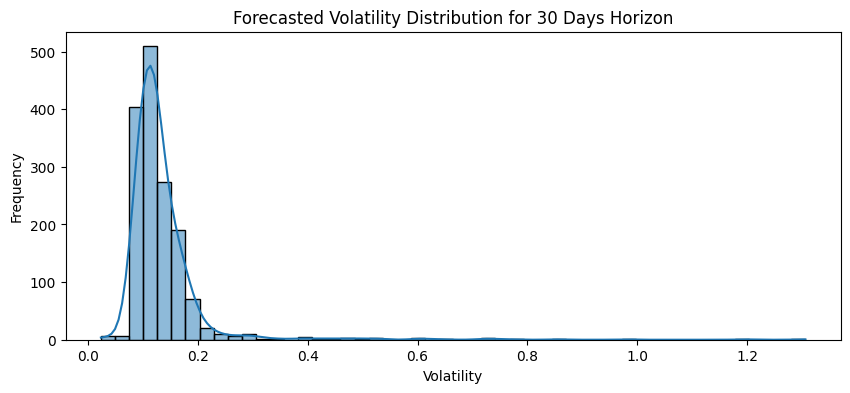

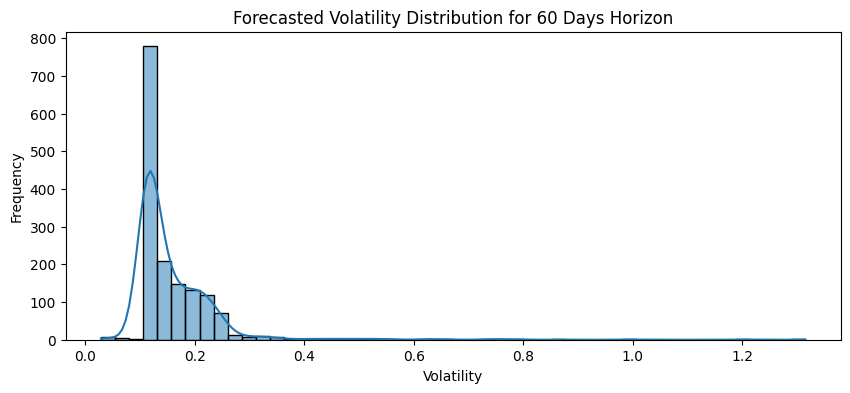

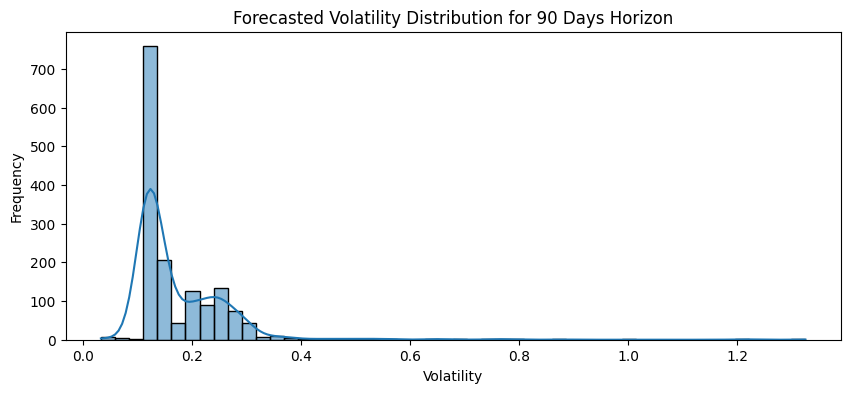

In [ ]:
for h in forecast_horizons:
    plt.figure(figsize=(10, 4))
    sns.histplot(comparison_df[h].dropna(), bins=50, kde=True)
    plt.title(f'Forecasted Volatility Distribution for {h} Days Horizon')
    plt.xlabel('Volatility')
    plt.ylabel('Frequency')
    plt.show()


<ipython-input-55-83a2f44b3b7a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strategy_data['Strategy_Returns'] = strategy_data['Log_Returns'] * strategy_data['Signal']
<ipython-input-55-83a2f44b3b7a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strategy_data['Cumulative_Strategy_Returns'] = (1 + strategy_data['Strategy_Returns']).cumprod()
<ipython-input-55-83a2f44b3b7a>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

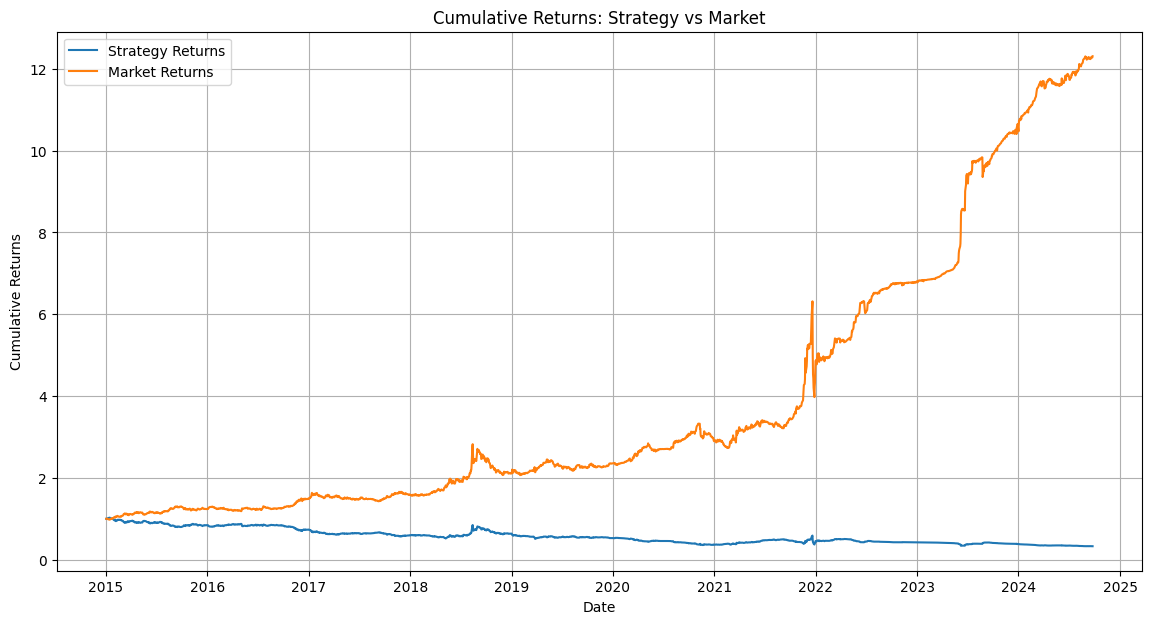

In [ ]:
# Define threshold for volatility breakout (e.g., 75th percentile)
vol_threshold = usd_try['EWMA_Volatility'].quantile(0.75)

# Generate signals
usd_try['Signal'] = 0  # 1 for buy, -1 for sell
usd_try.loc[usd_try['EWMA_Volatility'] > vol_threshold, 'Signal'] = 1
usd_try.loc[usd_try['EWMA_Volatility'] < vol_threshold, 'Signal'] = -1

# Shift signals to avoid look-ahead bias
usd_try['Signal'] = usd_try['Signal'].shift(1)

# Drop NaN values
strategy_data = usd_try.dropna(subset=['Signal'])

# Calculate strategy returns
strategy_data['Strategy_Returns'] = strategy_data['Log_Returns'] * strategy_data['Signal']

# Calculate cumulative returns
strategy_data['Cumulative_Strategy_Returns'] = (1 + strategy_data['Strategy_Returns']).cumprod()
strategy_data['Cumulative_Market_Returns'] = (1 + strategy_data['Log_Returns']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(strategy_data.index, strategy_data['Cumulative_Strategy_Returns'], label='Strategy Returns')
plt.plot(strategy_data.index, strategy_data['Cumulative_Market_Returns'], label='Market Returns')
plt.title('Cumulative Returns: Strategy vs Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Define threshold for volatility breakout (e.g., 75th percentile)
vol_threshold = aligned_forecasts.quantile(0.75).mean()

# Generate signals based on forecasted volatility exceeding the threshold
# We can choose to base the signal on a specific horizon or aggregate forecasts
# For simplicity, let's use the 30-day forecast

threshold_30d = aligned_forecasts[30].quantile(0.75)

# Create signals: 1 for buy, -1 for sell, 0 for hold
comparison_df['Signal'] = 0
comparison_df['Signal'] = np.where(comparison_df[30] > threshold_30d, 1, -1)

# Shift signals to avoid look-ahead bias (execute trades the next day)
comparison_df['Signal'] = comparison_df['Signal'].shift(1)

# Drop NaN values resulting from the shift
strategy_data = comparison_df.dropna(subset=['Signal'])

# Display the first few signals
print(strategy_data[['Signal']])


            Signal
2018-11-07    -1.0
2018-11-08    -1.0
2018-11-09    -1.0
2018-11-12    -1.0
2018-11-13    -1.0
...            ...
2024-09-18    -1.0
2024-09-19    -1.0
2024-09-20    -1.0
2024-09-23    -1.0
2024-09-24    -1.0

[1534 rows x 1 columns]


<ipython-input-53-72325937e67b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strategy_data['Strategy_Returns'] = strategy_data['Log_Returns'] * strategy_data['Signal']
<ipython-input-53-72325937e67b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strategy_data['Cumulative_Strategy_Returns'] = (1 + strategy_data['Strategy_Returns']).cumprod()
<ipython-input-53-72325937e67b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

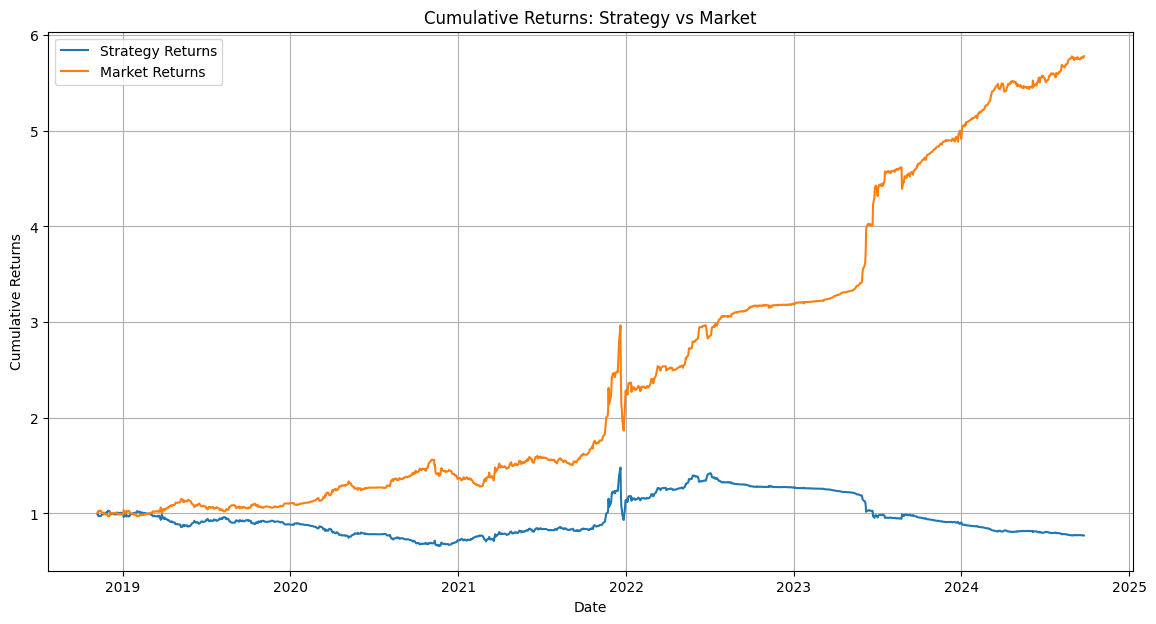

In [ ]:
# Calculate strategy returns by multiplying signals with actual returns
strategy_data['Strategy_Returns'] = strategy_data['Log_Returns'] * strategy_data['Signal']

# Calculate cumulative returns for the strategy and the market
strategy_data['Cumulative_Strategy_Returns'] = (1 + strategy_data['Strategy_Returns']).cumprod()
strategy_data['Cumulative_Market_Returns'] = (1 + strategy_data['Log_Returns']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(strategy_data.index, strategy_data['Cumulative_Strategy_Returns'], label='Strategy Returns')
plt.plot(strategy_data.index, strategy_data['Cumulative_Market_Returns'], label='Market Returns')
plt.title('Cumulative Returns: Strategy vs Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

# Define risk-free rate (e.g., 0.5% annual)
risk_free_rate = 0.005
daily_rf = risk_free_rate / 252

# Calculate excess returns
strategy_data['Excess_Returns'] = strategy_data['Strategy_Returns'] - daily_rf

# Sharpe Ratio
sharpe_ratio = (strategy_data['Excess_Returns'].mean() / strategy_data['Excess_Returns'].std()) * np.sqrt(252)

# Sortino Ratio
downside_returns = strategy_data['Strategy_Returns'][strategy_data['Strategy_Returns'] < 0]
sortino_ratio = (strategy_data['Strategy_Returns'].mean() / downside_returns.std()) * np.sqrt(252)

# Maximum Drawdown
cumulative_returns = strategy_data['Cumulative_Strategy_Returns']
rolling_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# Annualized Volatility
annualized_vol = strategy_data['Strategy_Returns'].std() * np.sqrt(252)

# Profit & Loss (PnL)
# Assuming starting with 1 unit of currency
pnl = strategy_data['Cumulative_Strategy_Returns'].iloc[-1] - 1

# Display the metrics
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Annualized Volatility: {annualized_vol:.2%}")
print(f"Profit & Loss (PnL): {pnl:.2f}")


Sharpe Ratio: -0.17
Sortino Ratio: -0.16
Maximum Drawdown: -48.00%
Annualized Volatility: 18.32%
Profit & Loss (PnL): -0.23


<ipython-input-52-409449668be1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strategy_data['Excess_Returns'] = strategy_data['Strategy_Returns'] - daily_rf


In [ ]:
# Plot drawdown
plt.figure(figsize=(14, 7))
plt.plot(drawdown.index, drawdown, label='Drawdown')
plt.title('Maximum Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()



NameError: name 'plt' is not defined

In [ ]:
print(usd_try)

NameError: name 'usd_try' is not defined